# Projet final Deep Learning

## Theme: Transfere de Style Artistique

### Model utilise : VGG19 preentrainer sur Imagene

Cette tache consiste a utilise une image d'entree appele image du contenu, et une image cible appele image de style(qui peut etre un tableau artistique etc..) que lon va fusionner afin que l'inmage d'entree puisse copier les caracteristique de l'iamge de de style

### Importation des bibliotheques

In [2]:
import os
import tensorflow as tf
import pandas as pd
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import matplotlib.pyplot as plt             #Representation des images
import matplotlib as mpl

import IPython.display as display
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import time                                  #Calcul du temps dexecution
import numpy as np                           #Calcul scientique , manipulation des tableau
from PIL import Image                        #Manipulation des images
import functools

In [3]:
# Chargement des  images 
# read_file lit une image et la sauvegarde comme binaire en memoire
image_contenu = tf.io.read_file("Ibrahim-Traore-en-Russie.jpg")
image_style = tf.io.read_file("vinci..mona.lisa-.la.joconde.-1503-05-.jpg")

In [4]:
#Décoder en tenseur (valeurs entières entre 0 et 255) 
#Dcode permet de decoder le fichier binaire en valeur pixel normal dune image(0-255)
image_contenu_decodee = tf.image.decode_image(image_contenu, channels=3) 
image_style_decodee = tf.image.decode_image(image_style, channels=3)

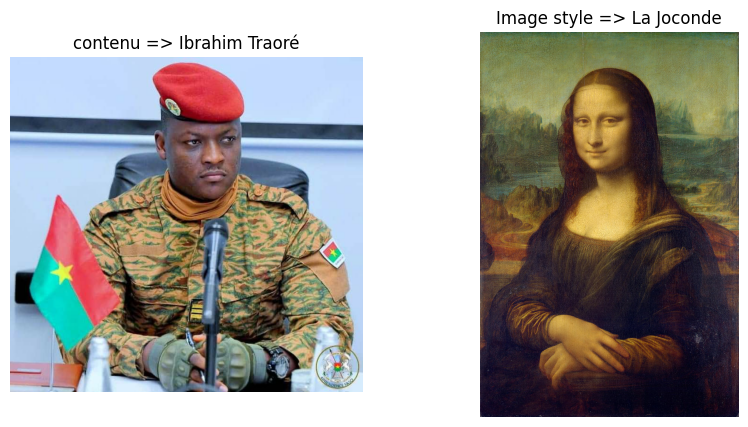

In [5]:
#Affichage des deux images
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(image_contenu_decodee)   #fonction de matplotlib qui prend un tableau numpy ou un tenseur tensorflow
plt.title("contenu => Ibrahim Traoré")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_style_decodee)
plt.title("Image style => La Joconde")
plt.axis('off')

plt.show()

### Chargement et preparation des images

In [6]:
# Fonction pour charger et traiter les images
#Fonction pour charger et préparer une image
def charger_et_preparer_image(path, taille=(512, 512)):
    """
    Charge une image à partir du disque, la redimensionne et la normalise.
    Retourne un tenseur prêt pour le modèle TensorFlow.
    """
    #Lire le fichier (en binaire)
    image = tf.io.read_file(path)

    #Décoder en image RGB
    image = tf.image.decode_image(image, channels=3)

    #Convertir en float32 et normaliser entre 0 et 1
    image = tf.image.convert_image_dtype(image, tf.float32)

    #Redimensionner (par défaut : 512x512)
    image = tf.image.resize(image, taille)

    #Ajouter la dimension batch (1 image)      
    image = image[tf.newaxis, :]               

    return image

In [7]:
#Cette focntion fait loperation inversion de la preparation
#La fonction reprend le tenseur sorti par le modèle (valeurs entre 0 et 1, float) et le reconvertit en image visible :
def tenseur_en_image(tensor):
  tensor = tensor*255                             # 0–1 → 0–255
  tensor = np.array(tensor, dtype=np.uint8)       # convertir en entiers
  if np.ndim(tensor)>3:                           #verifie si la dimesion batch > 3
    assert tensor.shape[0] == 1                   #verifie si le nombre dimage = 1    
    tensor = tensor[0]                            #on la suprime
  return Image.fromarray(tensor)

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:     #verifie sil ya une dimesion bathc
    image = tf.squeeze(image, axis=0) #supprimer la dim batch
#util car matplotlib ne comprend les tenseur avce une dim batch
  plt.imshow(image)
  if title:
    plt.title(title)

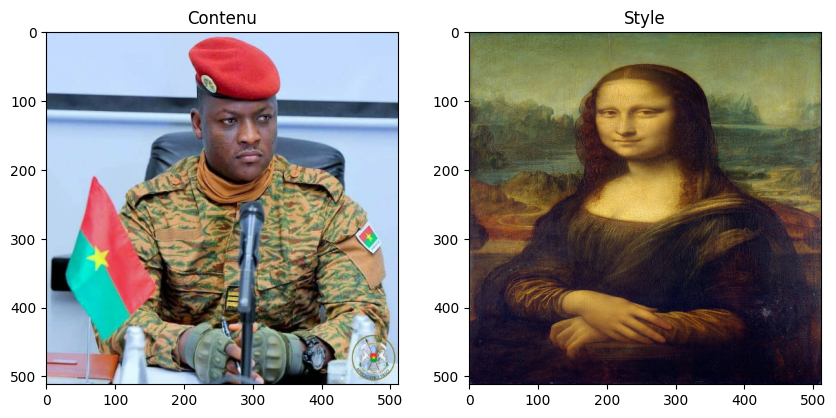

In [9]:
#
image_contenu = charger_et_preparer_image("Ibrahim-Traore-en-Russie.jpg")
image_style = charger_et_preparer_image("vinci..mona.lisa-.la.joconde.-1503-05-.jpg")
 
plt.subplot(1, 2, 1)
imshow(image_contenu, 'Contenu')

plt.subplot(1, 2, 2)
imshow(image_style, 'Style')

### Identification du contenu

In [12]:
x = tf.keras.applications.vgg19.preprocess_input(image_contenu*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [13]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('military_uniform', np.float32(0.15871352)),
 ('crutch', np.float32(0.07773886)),
 ('barracouta', np.float32(0.05387855)),
 ('paddle', np.float32(0.05218359)),
 ('coho', np.float32(0.046215538))]

### Chargement du model

In [14]:
# Afficher index, nom, et nombre de filtres (si applicable)
for i, layer in enumerate(vgg.layers):
    if hasattr(layer, 'filters'): #Verifier si la couche a un attribut filtre(car les pooling par exemple nont pas de filtre)
        print(f"{i:3} | {layer.name:25} | {layer.filters:5} filtres")
#les valeur :3, :25...permettent dajouter de lespace pour lafficher  
    else:
        print(f"{i:3} | {layer.name:25} | -")

  0 | input_layer               | -
  1 | block1_conv1              |    64 filtres
  2 | block1_conv2              |    64 filtres
  3 | block1_pool               | -
  4 | block2_conv1              |   128 filtres
  5 | block2_conv2              |   128 filtres
  6 | block2_pool               | -
  7 | block3_conv1              |   256 filtres
  8 | block3_conv2              |   256 filtres
  9 | block3_conv3              |   256 filtres
 10 | block3_conv4              |   256 filtres
 11 | block3_pool               | -
 12 | block4_conv1              |   512 filtres
 13 | block4_conv2              |   512 filtres
 14 | block4_conv3              |   512 filtres
 15 | block4_conv4              |   512 filtres
 16 | block4_pool               | -
 17 | block5_conv1              |   512 filtres
 18 | block5_conv2              |   512 filtres
 19 | block5_conv3              |   512 filtres
 20 | block5_conv4              |   512 filtres
 21 | block5_pool               | -
 22 | flatten   

In [15]:
# Choix des couches 
layers_du_contenu = ['block5_conv2'] 

layers_du_style = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

nbr_elt_contenu = len(layers_du_contenu)
nbr_elt_style = len(layers_du_style)
# Util pour le calcul des pertes

In [16]:
# Fonction pour la construction de notre model
def creation_model(layer_names):
    model =  tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    model.trainable = False # on bloque l'entrainement  nouveau du model
                            # on veut juste extraire les caracteristique en se servant du VGG19
    #Liste de couche que l'on veut recuperer la sortie                        
    sorties = [model.get_layer(name).output for name in layer_names] 
    model_creer = tf.keras.Model([model.input], sorties)
    return model_creer

# NB: vgg19 → le module (contenant la classe et les fonctions)
      #VGG19 → la classe qui construit le réseau de neurones

On crée un nouveau modèle  dont :

l’entrée est la même que VGG19 (model.input)

la sortie est les couches intermédiaires que l’on veut observer (sorties)

Résultat : un modèle qui prend une image et renvoie les features des couches choisies.

In [17]:
extracteur_style = creation_model(layers_du_style)
sortie_style = extracteur_style(image_style*255)


style_extractor(image_style*255) → on fait passer l’image de style dans le modèle VGG19 et on récupère :

la sortie de chaque couche de style choisie

ces sorties sont des tensors qui contiennent les caractéristiques de style de l’image (textures, motifs, couleurs…)

In [ ]:

#Statistiques des resultats obtenu
for name, output in zip(layers_du_style, sortie_style):
  print("============================")
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()
  print("============================")

#Chaq filtre (64) represente les caracteristique detecter


block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  657.06287
  mean:  17.801468

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  2037.779
  mean:  84.51543

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  4476.801
  mean:  77.43343

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  8467.114
  mean:  347.949

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  2548.7927
  mean:  28.187384



## Matrice de gram

À quoi ça sert ?

Le but : capturer le style de l’image.

Le style = comment les couleurs et les textures se mélangent, pas la forme exacte des objets.

La matrice Gram résume les relations entre toutes les textures de l’image.

On divise par le nombre de pixels pour que la taille de l’image ne change pas le style.

In [ ]:
def gram_matrix(tensor):
  # Calcul de la matrice Gram
  # tensor : sortie d'une couche VGG, forme = (batch, hauteur, largeur, canaux)
  # tf.linalg.einsum calcule les corrélations entre tous les canaux
  # 'bijc,bijd->bcd' signifie :
  #  b = batch, i = hauteur, j = largeur, c/d = canaux
  # On multiplie chaque canal avec tous les autres et on somme sur i,j
  result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
  # Récupère la taille spatiale de l'image (hauteur x largeur)
  input_shape = tf.shape(tensor)
  # Nombre de positions spatiales (pixels) pour normaliser
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  # Normalise la matrice Gram par le nombre de pixels
  # Cela permet de comparer des images de tailles différentes
  return result/(num_locations)

  #tf.linalg.einsum est une fonction qui fait des produits et des sommes sur des axes spécifiques d’un tenseur (ou plusieurs).

## Matrice de Gram dans le traitement d'images
Dans le domaine du traitement d'images, la matrice Gram est utilisée dans les applications de transfert de style, où l'objectif est de mélanger le contenu d'une image avec le style d'une autre. En calculant la matrice de Gram des cartes de caractéristiques extraites des réseaux de neurones convolutifs (CNN), les praticiens peuvent capturer la texture et le style des images. La matrice Gram sert de représentation des corrélations entre différentes caractéristiques, permettant la synthèse d'images visuellement attrayantes qui conservent le style artistique souhaité.

 Classe pour extraire automatiquement le style et le contenu d'une image avec VGG19,
 calculer les matrices Gram pour le style et organiser les résultats dans des dictionnaires prêts à l'emploi.


In [46]:
# Définition d'une classe personnalisée pour extraire le style et le contenu d'une image
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()      # Initialise la classe parente tf.keras.models.Model
    
    # Création d'un modèle VGG19 avec uniquement les couches spécifiées
    # Les couches incluent à la fois les couches de style et de contenu
    self.vgg = creation_model(style_layers + content_layers)

    # Stocke les noms des couches de style et de contenu
    self.style_layers = style_layers
    self.content_layers = content_layers

    # Nombre de couches de style (utile pour séparer les sorties plus tard)
    self.num_style_layers = len(style_layers)

    # On bloque l'entraînement du VGG19 pour ne pas modifier ses poids pré-entraînés
    self.vgg.trainable = False


  def call(self, inputs):
    "Expects float input in [0,1]"

    # VGG19 attend des valeurs entre 0 et 255, donc on multiplie l'image normalisée
    inputs = inputs*255.0

    # Prétraitement spécifique à VGG19 : soustraction des moyennes RGB
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Passage de l'image dans le modèle VGG19
    outputs = self.vgg(preprocessed_input)

    # Séparation des sorties en style et contenu
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calcul de la matrice Gram pour chaque sortie de style
    # La matrice Gram capture les corrélations entre les filtres → l'essence du style
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Création d'un dictionnaire pour les features de contenu
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
    
     # Création d'un dictionnaire pour les features de style
    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    # Retourne les dictionnaires contenant les features de contenu et de style
    return {'content': content_dict, 'style': style_dict}

  

In [47]:
#on crée un objet de la classe StyleContentModel
#ON lui dit qon veut utiliser les couches layers_du_style,layers_du_contenu

extractor = StyleContentModel(layers_du_style, layers_du_contenu)

#passage de limg dans lextracteur pour extracteur,pour extraire les features
results = extractor(tf.constant(image_contenu))

In [67]:
#Statistiques du style
print('Style:')
print('==================================')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print('==================================')

  print()


Style:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.054342516
    max:  46321.387
    mean:  705.90796

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  117776.0
    mean:  18323.246

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  416604.97
    mean:  20922.887

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4.378235e+06
    mean:  250264.58

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  127812.13
    mean:  2135.905



In [59]:
#statistique du contenu
print("Contenu:")
for name, output in sorted(results['content'].items()):
  print('==================================')
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print('==================================')



Contenu:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1692.2665
    mean:  17.349041


In [68]:
#recuperation des features
style_targets = extractor(image_style)['style']
content_targets = extractor(image_contenu)['content']

In [ ]:
image = tf.Variable(image_contenu)
#Transformer l'image de contenu en variable tensorflow
#Permettant de modifier l'image en temps reel

In [70]:
# Fonction pour limiter les valeurs des pixels entre 0 et 1
# Permet de garder l'image valide après chaque mise à jour pendant l'entraînement
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### Optimiseur pour mettre à jour les pixels de l’image générée afin de réduire la perte.

In [71]:
#learning_rate=taille de pas,beta_1=controle de lissage des gradients, epsilon=pour eviter la division par 0 lors des calcul  
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2    
content_weight=1e4  

style_weight → poids de la perte de style

Contrôle l’importance du style dans la transformation de l’image.

Une valeur plus grande → l’image générée ressemble plus au style de l’image de style.

content_weight → poids de la perte de contenu

Contrôle l’importance du contenu de l’image originale.

Une valeur plus grande → l’image générée garde mieux la structure de l’image de contenu

### Fonction de perte 

Cette fonction compare l’image générée avec l’image de style et l’image de contenu, calcule combien elle est “loin” de l’objectif, et retourne un score global que le modèle va essayer de réduire.

In [72]:
def style_content_loss(outputs):
    """
    Calcule la perte totale de style et de contenu pour une image générée.
    """
    # Récupérer les features de style et de contenu
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Perte de style : moyenne des différences au carré entre image générée et style cible
    style_loss = 0
    for name in style_outputs:
        style_loss += tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
    style_loss = style_loss * style_weight / nbr_elt_style
    
    # Perte de contenu : moyenne des différences au carré entre image générée et contenu cible
    content_loss = 0
    for name in content_outputs:
        content_loss += tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
    content_loss = content_loss * content_weight / nbr_elt_contenu
    
    # Perte totale = style + contenu
    return style_loss + content_loss


In [73]:
@tf.function() #→ transforme la fonction en graph TensorFlow pour que l’exécution soit plus rapide.

#fonction permettant de faire une etape dentrainement sur limage generer
def train_step(image):

  #enregistre toutes les opérations pour pouvoir calculer les gradients.
  with tf.GradientTape() as tape:
  #calcule les features de style et contenu de l’image générée.
    outputs = extractor(image)
  #calcule la perte totale pour cette image (style + contenu).
    loss = style_content_loss(outputs)
  #alcule le gradient de la perte par rapport à l’image pour indiquer comment modifier limage
  grad = tape.gradient(loss, image)
  #loptimiseur pour mettre a jour liamge en focntion du gradiant
  opt.apply_gradients([(grad, image)])
  #recadre les valeurs des pixels entre 0 et 1 pour que l’image reste valide.
  image.assign(clip_0_1(image))

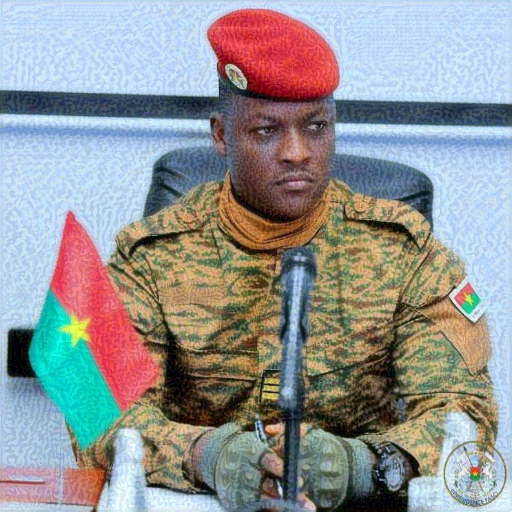

In [74]:
train_step(image)
train_step(image)
train_step(image)
tenseur_en_image(image)

# Appliquer plusieurs étapes d'entraînement sur l'image générée
# Chaque train_step modifie légèrement l'image pour se rapprocher
# du style de l'image de style tout en conservant le contenu
# tenseur_en_image permet d'afficher l'image actuelle après ces modifications

## Entrainement

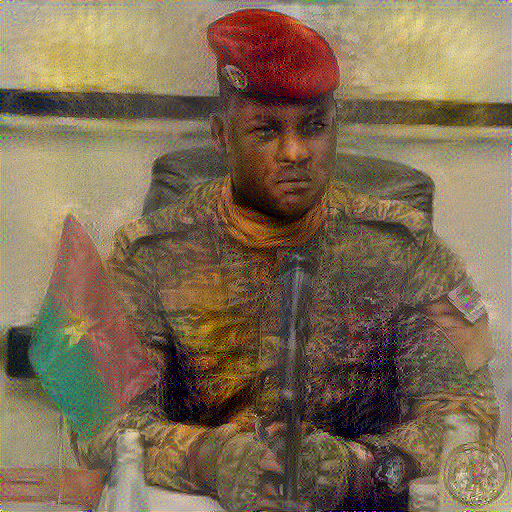

Etape d'entrainement: 1000
Total temps: 22305.8


In [76]:
start = time.time() #enregistre l'heure du debut

epochs = 10        #Nombre de cycle (10)
steps_per_epoch = 100 #(nombre de petites mises à jour (train_step) par cycle.)

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)  #aplique la transformation pour raprocher limage du style
    print(".", end='', flush=True)
  #On efface l’affichage précédent pour ne pas saturer la sortie 
  display.clear_output(wait=True)
  #On affiche l’image modifiée à ce stade
  display.display(tenseur_en_image(image))
  #On affiche le numéro de l’étape d’entraînement
  print("Etape d'entrainement: {}".format(step))
  
end = time.time() #calcul le temps final
print("Total temps: {:.1f}".format(end-start))

# OPTIMISATION